In [1]:
from pyxirr import xirr
import streamlit as st
import pandas as pd
import yfinance as yf
import numpy as np
import pandas_datareader as reader
#from scipy.stats import norm
from datetime import datetime
from datetime import timedelta
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib
import investpy as inv
plt.style.use('default')
import warnings 
warnings.filterwarnings(action='ignore')
import plotly.express as px
import plotly.graph_objects as go
import quantstats as qs
from matplotlib import colors
from scipy import stats

In [2]:



movimientos = pd.read_excel("records.xlsx", parse_dates=True)
movimientos = movimientos.set_index("Fecha")

opcion_seleccionada = "Omite monetarios"

if opcion_seleccionada == "Omite monetarios":
    movimientos = movimientos[(movimientos["Description"] != "ETF monetario") & (movimientos["Description"] != "Fondo monetario")]
    fecha_inicio = "2023-09-01"
else:
    fecha_inicio = "2023-01-01"

fecha_hoy = datetime.now()
fecha_formateada = fecha_hoy.strftime("%Y-%m-%d")

rango_fechas = pd.date_range(fecha_inicio, end=fecha_formateada, freq="D")
rango_fechas = rango_fechas[rango_fechas.dayofweek < 5]

# Download prices
precios = pd.DataFrame(index=rango_fechas)
for i in movimientos["Yahoo Ticker"].dropna().unique():
    precios[i] = yf.download(i, start=fecha_inicio, progress=False)["Adj Close"]

eurusd = yf.download("EURUSD=X", start=fecha_inicio, progress=False).resample("B").ffill()["Adj Close"]

precios["WBIT"] = yf.download("BTC-USD", start=fecha_inicio, progress=False).resample("B").ffill()["Adj Close"] / eurusd * 0.0002396
for ticker in ["JOE", "BN", "BAM"]:
    precios[ticker] = precios[ticker] / eurusd

precios = precios.fillna(method="ffill")

# Rename columns
column_mapping_prices = {
    'CSH2.PA': '0.0 ETF monetario', '0P00002BDB.F': '0.1 Fondo monetario', 'U3O8.DE': '1.6 Uranio',
    'ZPRV.DE': '1.3 USA Small Value', '0P0001AINF.F': '1.1 World', '0P0001AINL.F': '1.4 Emergentes',
    'SMCX.MI': '1.2 Europa Small', 'BN': '2.2 Brookfield Corp', 'JOE': '2.3 St Joe', 'TL0.DE': '2.1 Tesla',
    'WBIT': '1.5 ETF bitcoin', 'BAM': '2.4 Brookfield AM'
}

column_mapping_else = {'ETF monetario': '0.0 ETF monetario', 'Fondo monetario': '0.1 Fondo monetario', 'Uranio': '1.6 Uranio', 'USA Small Value': '1.3 USA Small Value', 'World': '1.1 World',
'Emergentes': '1.4 Emergentes', 'Europa Small': '1.2 Europa Small', 'Brookfield Corp': '2.2 Brookfield Corp', 
'St Joe': '2.3 St Joe', 'Tesla': '2.1 Tesla', 'ETF bitcoin': '1.5 ETF bitcoin', 'Brookfield AM': '2.4 Brookfield AM'
                    }

precios.rename(columns=column_mapping_prices, inplace=True)
precios = precios.sort_index(axis=1)

# Calculate returns
rendimientos = precios.pct_change()

# Download and calculate benchmark returns
benchmark = yf.download("SPYI.DE", start=fecha_inicio, progress=False).resample("B").ffill()["Adj Close"]
rendimiento_benchmark = benchmark.pct_change().fillna(0)

# Calculate positions
posiciones = pd.DataFrame(index=rango_fechas, columns=movimientos["Description"].unique())
for i in movimientos["Description"].unique():
    posiciones[i] = movimientos[movimientos["Description"] == i].cumsum()["Flow unidades"]
posiciones = posiciones.fillna(method="ffill").fillna(0)
posiciones.rename(columns=column_mapping_else, inplace=True)
posiciones = posiciones.sort_index(axis=1)

# Calculate cost
coste = pd.DataFrame(index=rango_fechas, columns=movimientos["Description"].unique())
for i in movimientos["Description"].unique():
    coste[i] = movimientos[movimientos["Description"] == i].cumsum()["Flow"]
coste = coste.fillna(method="ffill").fillna(0)
coste.rename(columns=column_mapping_else, inplace=True)
coste = coste[posiciones.columns]

# Calculate value and weights
valor = precios * posiciones
pesos = valor.divide(valor.sum(axis=1), axis=0)

# Calculate contribution and portfolio return
contribucion = pesos.shift() * rendimientos
rendimiento_portfolio = contribucion.sum(axis=1)

# Calculate P&L
pl = valor.add(coste)

# Update movimientos
movimientos.replace(column_mapping_else, inplace=True)
movimientos["Ud sim benchmark"] = (-movimientos["Flow"] / benchmark.loc[movimientos.index]).cumsum()





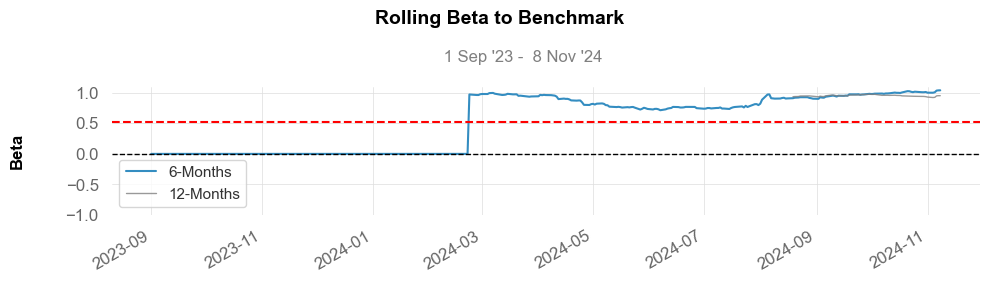

In [ ]:
qs.plots.snapshot()

                           Strategy
-------------------------  ----------
Start Period               2023-09-01
End Period                 2024-11-08
Risk-Free Rate             0.0%
Time in Market             99.0%

Cumulative Return          36.29%
CAGR﹪                     19.69%

Sharpe                     1.85
Prob. Sharpe Ratio         97.58%
Smart Sharpe               1.61
Sortino                    2.69
Smart Sortino              2.34
Sortino/√2                 1.9
Smart Sortino/√2           1.66
Omega                      1.37

Max Drawdown               -9.92%
Longest DD Days            77
Volatility (ann.)          14.12%
Calmar                     1.99
Skew                       -0.6
Kurtosis                   3.75

Expected Daily %           0.1%
Expected Monthly %         2.09%
Expected Yearly %          16.74%
Kelly Criterion            15.4%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.36%
Expected Shortfall (cVaR)  -1.36%

Max Consecutive Wins       10


None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-07-17,2024-08-05,2024-09-23,69,-9.915836,-9.148482
2,2023-09-15,2023-10-30,2023-11-30,77,-8.948830,-8.862691
3,2024-03-29,2024-04-19,2024-05-13,46,-5.092533,-4.933476
4,2024-05-21,2024-06-11,2024-07-10,51,-3.153039,-3.119764
5,2024-10-21,2024-11-04,2024-11-05,16,-2.904802,-2.638995


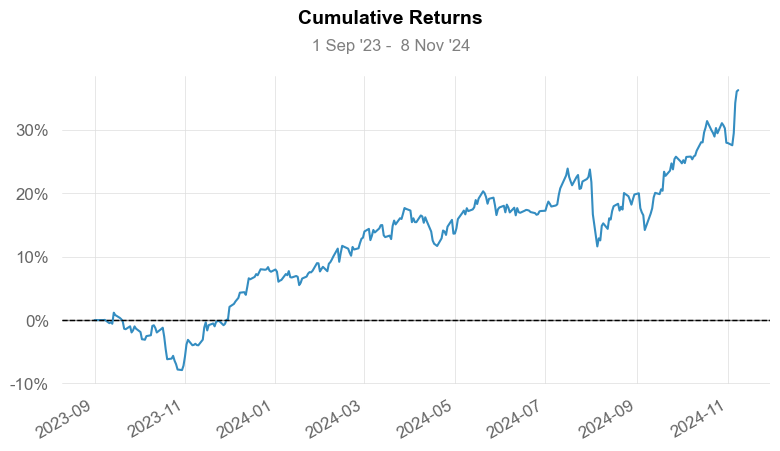

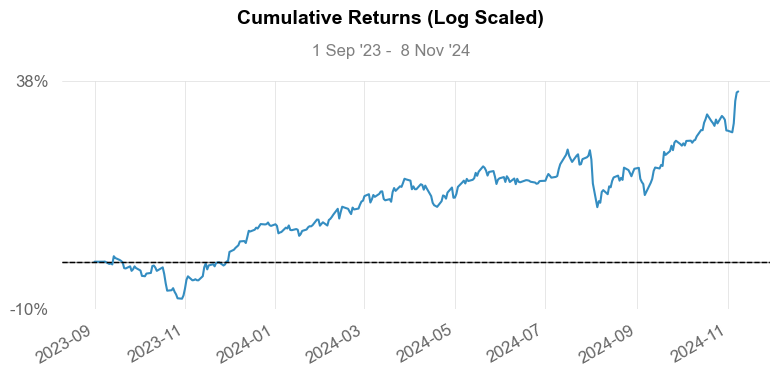

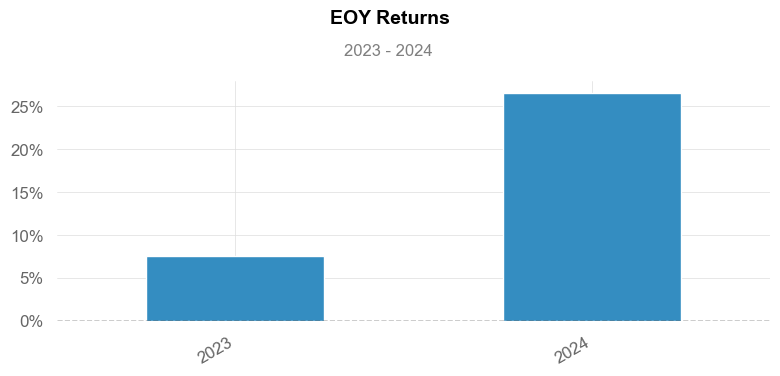

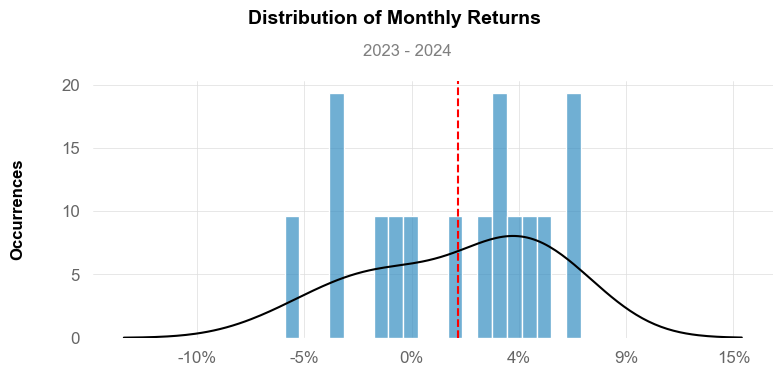

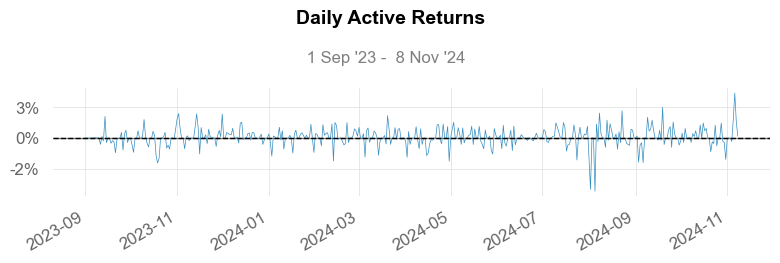

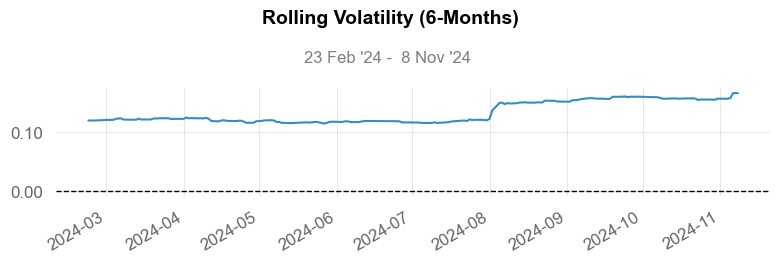

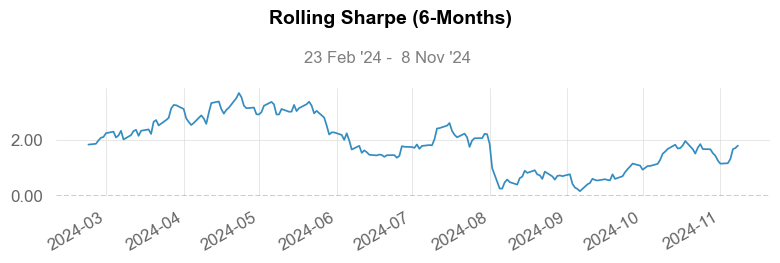

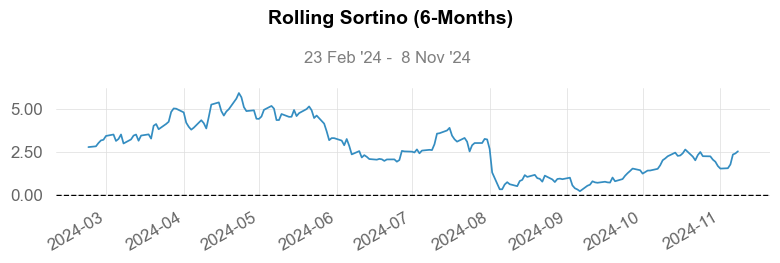

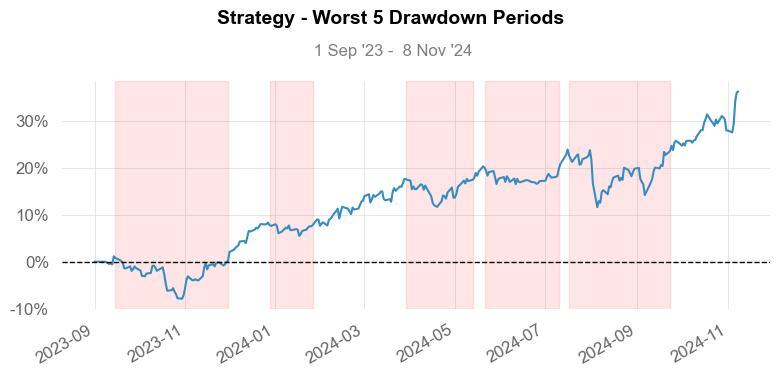

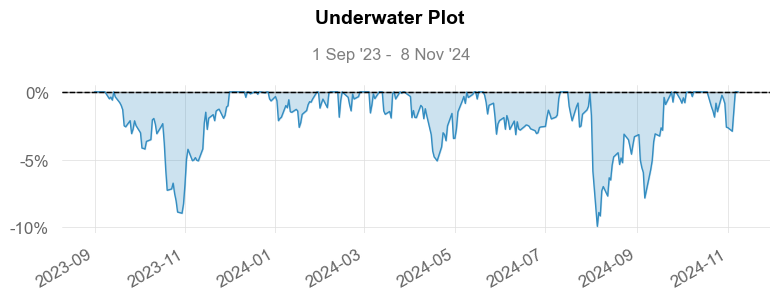

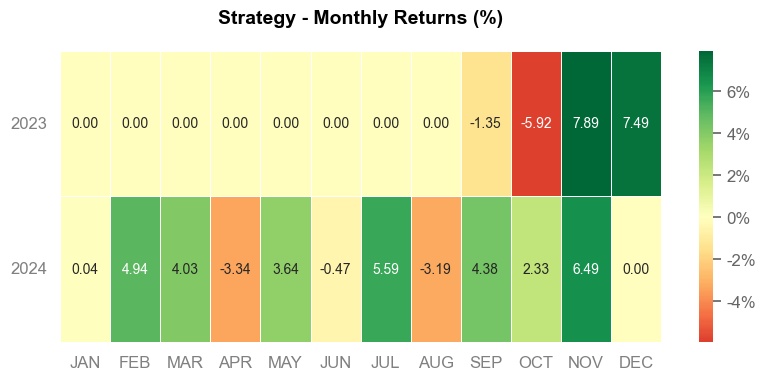

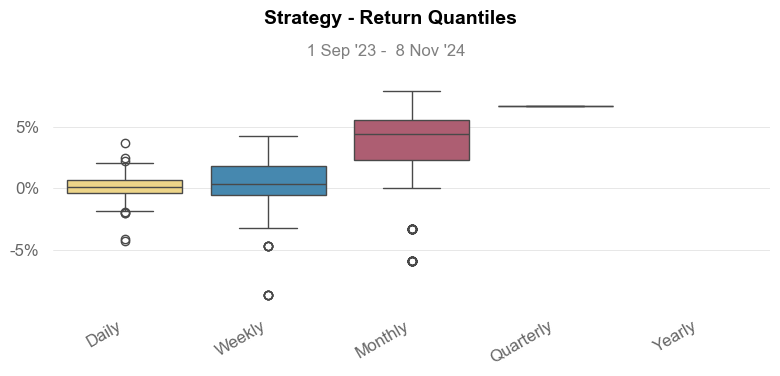

In [6]:
qs.reports.full(rendimiento_portfolio)

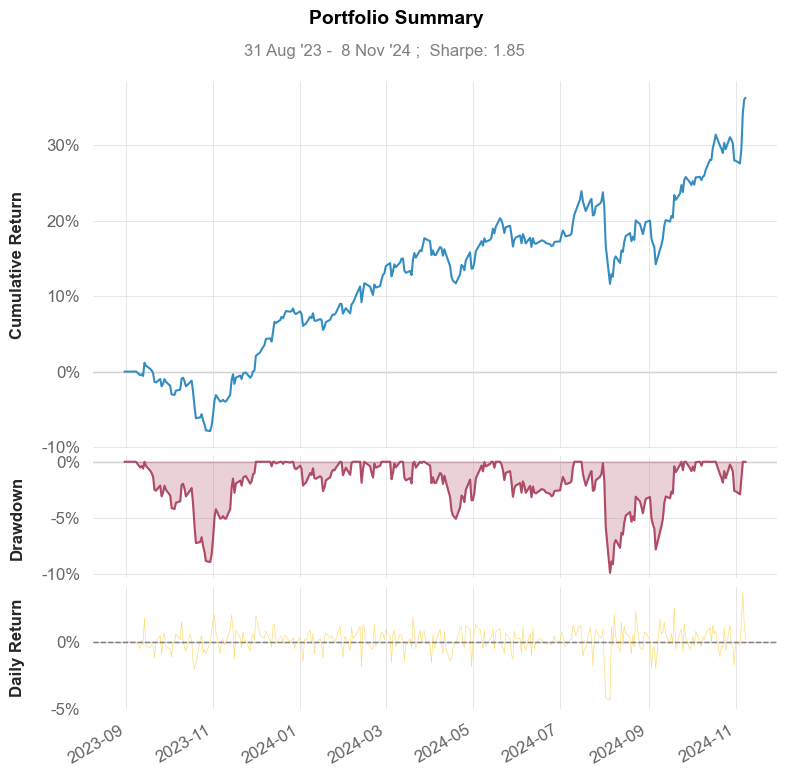

In [3]:
qs.plots.snapshot(rendimiento_portfolio,show=False,figsize=(8,8))